In [8]:
import sys
import numpy as np

sys.path.append(f"./../")
from src import SpaceEfficientVQF, Clause

In [9]:
m = 699991817269
# m = 7 * 11
vqf = SpaceEfficientVQF(m)

In [10]:
n_vars_list = []
comp_ratio_list = []
for c in vqf.selected_clauses:
    if c != 0:
        #display(c)
        #clause = Clause(c)
        n_vars = len(c.pq_part.free_symbols)
        n_vars_list.append(n_vars)
        table = c.reduce_space()
        comp_ratio = np.abs(table.calc_r())
        comp_ratio_list.append(comp_ratio)

3
2.0
5
3.0
7
3.0
9
3.0
11
4.0
13
4.0
15
4.0
16
3.3202999942307514
14
2.9052624949519075
12
2.4902249956730635
10
2.0751874963942187
8
1.6601499971153757
6
1.2451124978365318
4
0.8300749985576878
2
0.4150374992788439


In [11]:
import matplotlib.pyplot as plt

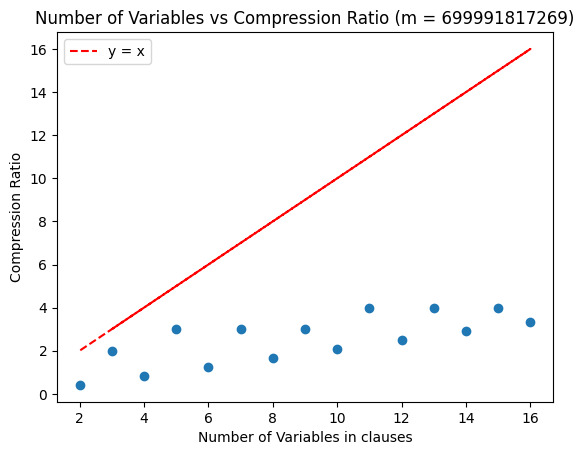

In [12]:
plt.scatter(n_vars_list, comp_ratio_list)
# Add labels and legend
plt.xlabel('Number of Variables in clauses')
plt.ylabel('Compression Ratio')
# Add a title
plt.title(f'Number of Variables vs Compression Ratio (m = {m})')
# Add reference line y = x
plt.plot(n_vars_list, n_vars_list,'--', color='red', label="y = x")
plt.legend()
plt.show()

In [13]:
m_list = [31767139, 1078985291482493, 22959642648148109382481, 939201124946069670424781654479]